<a href="https://colab.research.google.com/github/yashikesarwani/NLP_NER/blob/master/NER_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Dataset used (ner_dataset.csv)-> Annotated Corpus for Named Entity Recognition
# Feature Engineered Corpus annotated with IOB and POS tags

### Dataset Description
geo = Geographical Entity <br>
org = Organization <br>
per = Person <br>
gpe = Geopolitical Entity <br>
tim = Time indicator <br>
art = Artifact <br>
eve = Event <br>
nat = Natural Phenomenon <br>
</br></br>
<b>Observations :</b> <br>
1. There are total 47959 sentences in the dataset. <br>
2. Total Words Count = 1048575 <br>
3. Target Data Column: Tag <br>
4. Number unique words in the dataset are 35178. <br>
5. Total 17 lables (Tags). <br>

  

#### Installing Requirements

In [2]:
!pip install seqeval
!pip install sklearn_crfsuite

### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import json   
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Dropout
from keras.models import Model, Input
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn_crfsuite.metrics import flat_classification_report
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import text_to_word_sequence

### Reading and Exploring Dataset

In [4]:
#Reading the csv file
df = pd.read_csv('/content/drive/My Drive/Edureka ML/NLP from Machine Learning University/NER/ner_dataset.csv', encoding = "ISO-8859-1")

In [5]:
#Display first 5 rows
df.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
# Exploring the dataset
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 14281,the,NN,O
freq,1,52573,145807,887908


In [7]:
# Displaying the unique Tags
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [8]:
# Checking if there is any null values in the datset
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [9]:
# Fillin up the null values
df = df.fillna(method = 'ffill')
df.head(5)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


### Data Preprocessing

In [10]:
# This is a class te get sentence. Each sentence will be list of tuples with its tag and pos.
class sentence(object):
  def __init__(self, df):
    self.n_sent = 1
    self.df = df
    self.empty = False
    agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),s['POS'].values.tolist(),s['Tag'].values.tolist())]
    self.grouped = self.df.groupby("Sentence #").apply(agg)
    self.sentences = [s for s in self.grouped]
      
  def get_text(self):
    try:
      s = self.grouped['Sentence: {}'.format(self.n_sent)]
      self.n_sent +=1
      return s
    except:
      return None

In [11]:
# Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [12]:
# sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [13]:
# Getting all the sentences in the dataset.
sentences = getter.sentences

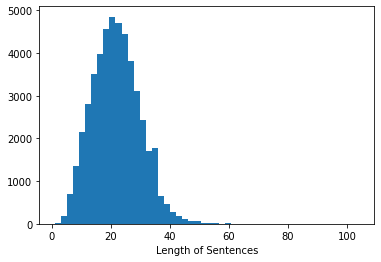

In [14]:
# Length of the sentences as histograms
plt.hist([len(s) for s in sentences],bins= 50)
plt.xlabel("Length of Sentences")
plt.show()

### Parameters for LSTM Model

In [15]:
# Number of data points passed in each iteration
batch_size = 64 
# Passes through entire dataset
epochs = 5
# Maximum length of review
max_len = 75 
# Dimension of embedding vector
embedding = 40
# LSTM units
LSTM_N = 50

### Data Preprocessing

In [16]:
# Getting unique words and labels from data
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())

# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [17]:
print("The word Google is identified by the index: {}".format(word_to_index["Google"]))
print("The label B-org for the organization is identified by the index: {}".format(tag_to_index["B-org"]))

The word Google is identified by the index: 4417
The label B-org for the organization is identified by the index: 6


In [18]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

In [19]:
# Padding each sequence to have same length of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [20]:
# Convert label to index
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [21]:
num_tag = df['Tag'].nunique()

# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

### Train and Test Set split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [23]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (40765, 75)
Size of training output data :  (40765, 75, 18)
Size of testing input data :  (7194, 75)
Size of testing output data :  (7194, 75, 18)


### Sentence and the labels representation before and after preprocessing

In [24]:
# Let's check the first sentence before and after processing.
print('================ Before Processing first sentence: =============\n', ' '.join([w[0] for w in sentences[0]]))
print('\n\n================ After Processing first sentence: ==============\n ', X[0])

================ Before Processing first sentence: =============
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .


================ After Processing first sentence: ==============
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 11 17  3 18 19 20 21 22 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [25]:
# First label before and after processing.
print('================= Before Processing first sentence: =================\n', ' '.join([w[2] for w in sentences[0]]))
print('\n\n================= After Processing first sentence: ==================\n ', y[0])

================= Before Processing first sentence: =================
 O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O


================= After Processing first sentence: ==================
  [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### Model Architecture

In [26]:

num_tags = df['Tag'].nunique()

# max_len dimensional word indices as input
input = Input(shape=(max_len,))
 
# Embedding layer of 40 length output (40 dim embedding will be generated)
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len)(input)
 
# Bidirectional LSTM to learn from both forward as well as backward context
model = Bidirectional(LSTM(units=LSTM_N, return_sequences=True, recurrent_dropout=0.1))(model)
 
# Adding a TimeDistributedDense, to applying a Dense layer on each max_len timesteps
out = TimeDistributed(Dense(num_tags+1, activation="softmax"))(model) # softmax output layer
model = Model(input, out)
model.summary() 


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 75, 40)            1407200   
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 100)           36400     
_________________________________________________________________
time_distributed (TimeDistri (None, 75, 18)            1818      
Total params: 1,445,418
Trainable params: 1,445,418
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [28]:
checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/Edureka ML/NLP from Machine Learning University/NER/model_BiLSTM.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=10, validation_split=0.1, callbacks=[checkpointer])

Epoch 1/10
574/574 [==============================] - 104s 182ms/step - loss: 0.2939 - accuracy: 0.9380 - val_loss: 0.1097 - val_accuracy: 0.9658
Epoch 2/10
574/574 [==============================] - 106s 185ms/step - loss: 0.0738 - accuracy: 0.9791 - val_loss: 0.0512 - val_accuracy: 0.9861
Epoch 3/10
574/574 [==============================] - 106s 184ms/step - loss: 0.0377 - accuracy: 0.9897 - val_loss: 0.0398 - val_accuracy: 0.9886
Epoch 4/10
574/574 [==============================] - 105s 183ms/step - loss: 0.0285 - accuracy: 0.9919 - val_loss: 0.0374 - val_accuracy: 0.9892
Epoch 5/10
574/574 [==============================] - 104s 182ms/step - loss: 0.0237 - accuracy: 0.9930 - val_loss: 0.0361 - val_accuracy: 0.9895
Epoch 6/10
574/574 [==============================] - 104s 181ms/step - loss: 0.0205 - accuracy: 0.9937 - val_loss: 0.0361 - val_accuracy: 0.9896
Epoch 7/10
574/574 [==============================] - 104s 180ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.0365 -

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plotting Training and Validation Accuracy

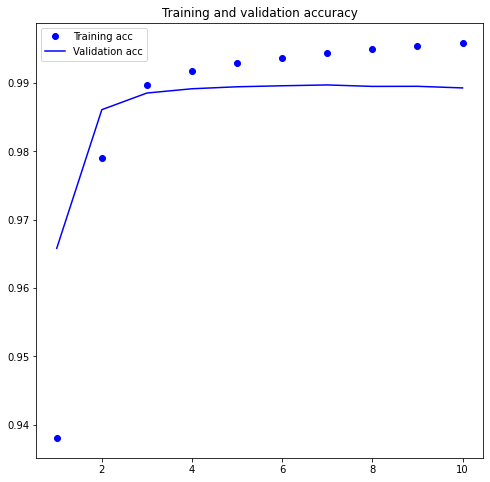

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### Plotting Training and Validation Loss

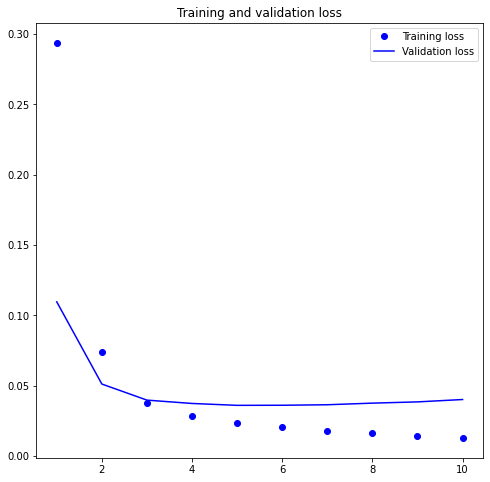

In [31]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Model Evaluation & Testing Score

In [32]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [33]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [34]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 85.9%


In [35]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

       B-art       0.24      0.09      0.12        47
       B-eve       0.47      0.16      0.24        56
       B-geo       0.85      0.87      0.86      5594
       B-gpe       0.96      0.93      0.94      2364
       B-nat       0.45      0.14      0.21        37
       B-org       0.75      0.70      0.72      2943
       B-per       0.82      0.80      0.81      2573
       B-tim       0.89      0.87      0.88      3101
       I-art       0.05      0.02      0.03        43
       I-eve       0.24      0.15      0.18        41
       I-geo       0.77      0.82      0.80      1107
       I-gpe       0.80      0.44      0.57        27
       I-nat       0.00      0.00      0.00         8
       I-org       0.76      0.75      0.76      2341
       I-per       0.87      0.82      0.85      2639
       I-tim       0.77      0.72      0.74       993
           O       0.99      0.99      0.99    133327
         PAD       1.00    

### Model Testing and Representation

In [36]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b

p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))

# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 5322 of 7194 (Test Set)
Word           ||True ||Pred
The            : O     O
Cuban          : B-gpe B-gpe
leader         : O     O
turned         : O     O
80             : O     O
in             : O     O
August         : B-tim B-tim
,              : O     O
but            : O     O
the            : O     O
festivities    : O     O
were           : O     O
postponed      : O     O
to             : O     O
allow          : O     O
him            : O     O
time           : O     O
to             : O     O
recover        : O     O
.              : O     O


### Model Loading & Retrival

In [37]:
reconstructed_model = keras.models.load_model("/content/drive/My Drive/Edureka ML/NLP from Machine Learning University/NER/model_BiLSTM.h5")

In [38]:
pred = reconstructed_model.predict(X_test)
print("Predicted Probabilities on Test Set:\n",pred.shape)
# taking tag class with maximum probability
pred_index = np.argmax(pred, axis=-1)
print("Predicted tag indices: \n",pred_index.shape)

Predicted Probabilities on Test Set:
 (7194, 75, 18)
Predicted tag indices: 
 (7194, 75)


In [39]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = reconstructed_model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 3227 of 7194 (Test Set)
Word           ||True ||Pred
The            : O     O
Algerian       : B-gpe B-gpe
president      : O     O
later          : O     O
visited        : O     O
some           : O     O
of             : O     O
the            : O     O
wounded        : O     O
at             : O     O
a              : O     O
local          : O     O
hospital       : O     O
.              : O     O


In [40]:

X_test.shape

(7194, 75)

In [41]:
#3108

### Reading some sentences, doing their preprocesing and predictions on them to find their security and securities as per the rules using symbols.csv given file

There are two sentences in the test data. We will find their security and securities as per the given rules.

In [42]:
test_data = pd.read_csv("/content/drive/My Drive/Edureka ML/NLP from Machine Learning University/NER/test_data.csv")

In [43]:
test_data.head(5)

,Unnamed: 0,Sentence #,Word,POS,Tag
0,0,Sentence: 1,Apple,NNP,B-org
1,1,Sentence: 1,",",IN,O
2,2,Sentence: 1,Amazon,NNP,B-org
3,3,Sentence: 1,and,CC,O
4,4,Sentence: 1,Microsoft,NNP,B-org


In [44]:
# Process test data and make predictions and find security and securities

In [45]:
# Creating a vocabulary
words = list(set(test_data["Word"].values))
words.append("ENDPAD")

word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}

In [46]:
getter = sentence(test_data)
sentences = getter.sentences
sentences

[[('Apple', 'NNP', 'B-org'),
  (',', 'IN', 'O'),
  ('Amazon', 'NNP', 'B-org'),
  ('and', 'CC', 'O'),
  ('Microsoft', 'NNP', 'B-org'),
  ('are', 'VBP', 'O'),
  ('reporting', 'VBG', 'O'),
  ('earnings', 'NN', 'O'),
  ('after', 'IN', 'O'),
  ('market', 'NNS', 'O'),
  ('close', 'VB', 'O'),
  ('on', 'IN', 'O'),
  ('April', 'NNP', 'B-tim'),
  ('30th', 'DT', 'I-time'),
  ('.', '.', 'O')],
 [('Apple', 'NNP', 'B-org'),
  ('and', 'CC', 'O'),
  ('Amazon', 'NNP', 'B-org'),
  ('started', 'JJ', 'O'),
  ('working', 'VBG', 'O'),
  ('on', 'IN', 'O'),
  ('COVID-19', 'NN', 'O'),
  ('tracing', 'NN', 'O'),
  ('application', 'NNP', 'O'),
  ('.', '.', 'O'),
  ('AAPL', 'NNP', 'B-org'),
  ('stock', 'NN', 'O'),
  ('went', 'VBD', 'O'),
  ('up', 'RP', 'O'),
  ('by', 'IN', 'O'),
  ('1', 'NN', 'O'),
  ('%', 'DT', 'O'),
  ('.', '.', 'O')]]

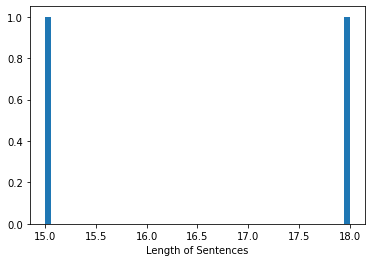

In [47]:
plt.hist([len(s) for s in sentences],bins= 50)
plt.xlabel("Length of Sentences")
plt.show()

In [48]:
Xtest = [[word_to_index[w[0]] for w in s] for s in sentences]
# Padding each sequence to have same length  of each word
Xtest = pad_sequences(maxlen = max_len, sequences = Xtest, padding = "post", value = word_to_index["PAD"])

Xtest.shape

(2, 75)

In [49]:
tags = list(test_data['Tag'].unique())

tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2tag = {i: w for w, i in tag_to_index.items()}

# Convert label to index
ytest = [[tag_to_index[w[2]] for w in s] for s in sentences]
# padding
ytest = pad_sequences(maxlen = max_len, sequences = ytest, padding = "post", value = tag_to_index["PAD"])

num_tag = df['Tag'].nunique()
# One hot encoded labels
ytest = [to_categorical(i, num_classes = num_tag + 1) for i in ytest]

In [50]:
# Let's check the first sentence before and after processing.
print('================Before Processing first sentence : =============\n', ' '.join([w[0] for w in sentences[0]]))
print('\n\n================After Processing first sentence : ==============\n ', X[0])

================Before Processing first sentence : =============
 Apple , Amazon and Microsoft are reporting earnings after market close on April 30th .


================After Processing first sentence : ==============
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 11 17  3 18 19 20 21 22 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [51]:
pred = reconstructed_model.predict(Xtest)
print("Predicted Probabilities on Test Set:\n",pred.shape)
# taking tag class with maximum probability
pred_index = np.argmax(pred, axis=-1)
print("Predicted tag indices: \n",pred_index.shape)

Predicted Probabilities on Test Set:
 (2, 75, 18)
Predicted tag indices: 
 (2, 75)


In [52]:
# security => 1. Most Common or 2. 1st one if 2 or more have same number or 3. if article name = any company name then that becomes security.
# security and securities are only printed in ticker forms.

In [53]:
# ALGORITHM
# 1. Convert all the securities into the ticker forms from the given csv files of symbols
# 2. find the most common one and first one if there are more than one having same number
# 3. return security find in step 2

In [55]:
def security(i):
  l = []
  
  pred = reconstructed_model.predict(np.array([Xtest[i]]))
  pred = np.argmax(pred, axis=-1) 
  true = np.argmax(ytest[i], -1)   

  for w, p in zip(Xtest[i], true):
    if w!= 0 and p!= 0  and idx2tag[p][-3:] == "org":
      l.append(words[w-2])   

  df = pd.read_csv("/content/drive/My Drive/Edureka ML/NLP from Machine Learning University/NER/symbols.csv")
  #df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)
  
  securities = []
  for i in range(len(l)):
    for index, row in df.iterrows():
      if l[i] == row["symbol"]:
        securities.append(row["symbol"])
      else:
        if (row["company"].find(l[i]) != -1):
          securities.append(row["symbol"])  

  security = []
  # Create a panda DataFrame using the list securities
  dff=pd.DataFrame({'Number': securities})
  security.append(dff.Number.mode()[0])
  print("security:",security)
  print("securities: ",securities)

  # Data to be written   
  dictionary ={   
    "security": security ,  
    "securities": securities  
  }   
       
  # Serializing json for Json representation with two attributes security and securities  
  print("\n") 
  json_object = json.dumps(dictionary, indent = 4)   
  print(json_object)


def sentence_representation(i):
  #Displaying one full sentence
  getter = sentence(test_data)
  sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
  print(sentences[i])
  return "\n"

In [56]:
sentence_representation(0)
security(0)

Apple , Amazon and Microsoft are reporting earnings after market close on April 30th .
security: ['AAPL']
securities:  ['AAPL', 'AMZN', 'MSFT']


{
    "security": [
        "AAPL"
    ],
    "securities": [
        "AAPL",
        "AMZN",
        "MSFT"
    ]
}


In [57]:
sentence_representation(1)
security(1)

Apple and Amazon started working on COVID-19 tracing application . AAPL stock went up by 1 % .
security: ['AAPL']
securities:  ['AAPL', 'AMZN', 'AAPL']


{
    "security": [
        "AAPL"
    ],
    "securities": [
        "AAPL",
        "AMZN",
        "AAPL"
    ]
}


In [57]:
# THANK YOU!